# Circuit Knitting Example

## Step 1: Create a circuit to cut

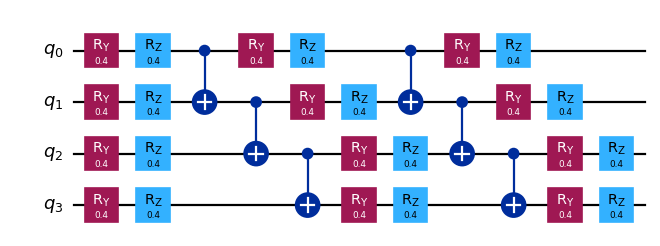

In [30]:
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(4, entanglement="linear", reps=2).decompose()
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

qc.draw("mpl", scale=0.8)

## Step 2: Specify an observable

In [31]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

## Step 3: Partition circuit and observables

In [32]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

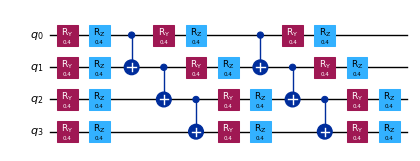

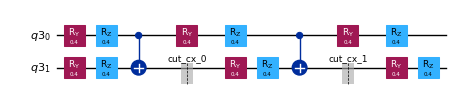

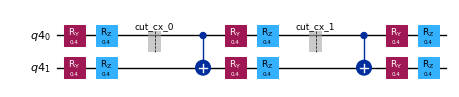

In [33]:
display(qc.draw("mpl", scale=.5))
for sc in subcircuits.values():
    display(sc.draw("mpl", scale=.5))

In [34]:
display(observable)
for so in subobservables.values():
    display(so)

SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])

PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX'])

PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])

## Step 4: Calculate the sampling overhead

In [35]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
for b in bases:
    print(f"  - num_qbits = {b.num_qubits}, overhead = {b.overhead}")
    

Sampling overhead: 81.0
  - num_qbits = 2, overhead = 9.0
  - num_qbits = 2, overhead = 9.0


## Step 5: Generate experiments to run on the backend

In [36]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

## Step 6: Choose a backend

In [37]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

## Step 7: Prepare subexperiments for the backend

In [38]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

## Step 8: Run the subexperiments

In [39]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(session=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

/tmp/ipykernel_9095/3971998279.py:6: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = SamplerV2(session=batch)


## Step 9: Reconstruct the expectation values

In [40]:
from circuit_knitting.cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

## Step 10: Compare the reconstructed expectation values with the exact expectation value

In [41]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.58025157
Exact expectation value: 0.56254612
Error in estimation: 0.01770545
Relative error in estimation: 0.03147378
